Preamble

In [1]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy.ma as ma


from mpl_toolkits.axes_grid1 import make_axes_locatable #for subplot colorbars
from matplotlib.pyplot import cm


# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 8, \
                            'figure.facecolor': (1, 1, 1, 0),'font.sans-serif':'Latin Modern Math'}

from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

%matplotlib inline

# Calculating the G, the normalized correlation function

In [2]:
def Calculate_G(image_names, start, time, lags):
    "this function takes image names, a sequence of time and a desired amount of lags"
    "and calculates G, mean quantities, maps"

    def calculate_G(metapixels_a, metapixels_b):
        "this function calculates the value of the normalized correlation"
        "function between metapixels"
        a = np.nanmean((metapixels_a * metapixels_b), axis=(2, 3))
        b = np.nanmean(metapixels_a, axis=(2, 3))
        c = np.nanmean(metapixels_b, axis=(2, 3))
        d = np.nanstd(metapixels_a, axis=(2, 3))
        e = np.nanstd(metapixels_b, axis=(2, 3))

        G = (a - (b * c)) / (d * e)
        return G

    def wholefield_stats(spatial_map, mask):
        map_mean = []
        map_var = []
        for i in range(len(spatial_map)):
            masked_map = ma.masked_array(spatial_map[i], mask=mask)
            map_mean.append(np.nanmean(masked_map))
            map_var.append(np.nanvar(masked_map))
        map_mean = np.asarray(map_mean)
        map_var = np.asarray(map_var)
        return map_mean  #, map_var
##################################################################################################################

#this variable is a list which contains each timestep

    G_time_lags = [[] for _ in range(len(time))]
    sandpile_mean = [[] for _ in range(len(time))]
    sandpile_var = [[] for _ in range(len(time))]

    i = 0

    # this is the size of the metapixels, defined outside of the loop
    size = 10

    for t in time:
        #this is just to make t an interger rather than a float so that t can be used as a list index
        t = int(t)

        #the index of each image (i.e. the frame number) is the iterator t plus 11, the time where grains first
        #enter the frame
        speckle_a = Image.open(image_names[t + start])
        speckle_a = np.asarray(speckle_a)[y_min:y_max, x_min:x_max]

        lenr, lenc = int(speckle_a.shape[0] / size), int(speckle_a.shape[1] /
                                                         size)
        metapixels_a = speckle_a.reshape(lenr, size, lenc,
                                         size).transpose(0, 2, 1, 3)

        mp_a_mean = np.nanmean(metapixels_a, axis=(2, 3))
        metapixels_a = np.subtract(metapixels_a,
                                   mp_a_mean[..., np.newaxis, np.newaxis])

##################################################################################################################
        l = 0
        G_lags = [[] for _ in range(lags)]

        # this loop is for each lag
        for lag in range(lags):

            # choosing two speckle images
            speckle_b = Image.open(image_names[lag + t + start])
            speckle_b = np.asarray(speckle_b)[y_min:y_max, x_min:x_max]

            metapixels_b = speckle_b.reshape(lenr, size, lenc,
                                             size).transpose(0, 2, 1, 3)
            mp_b_mean = np.nanmean(metapixels_b, axis=(2, 3))
            metapixels_b = np.subtract(metapixels_b,
                                       mp_b_mean[..., np.newaxis, np.newaxis])

            G_lags[l] = (calculate_G(metapixels_a, metapixels_b))
            
            l += 1
        #this is a new piece to ensure that any correlation values < 0 are set to 0. 
        #(negative correlations are unphysical)
#         G_lags[G_lags <= 0] = 0
##################################################################################################################
        G_time_lags[i] = G_lags
        sandpile_mean[i] = wholefield_stats(G_time_lags[i], mask=~binary)

        i += 1
        print(t+start)

    return G_time_lags, sandpile_mean

# Tapping

In [ ]:
os.chdir('/media/nakul/Backup Plus/Data/DWS_RawExperimentPhotos/feb_13_tapping/long_tapping')

In [ ]:
import glob
import natsort

image_names = []

for name in glob.glob('img_*.jpg'):
    image_names.append(name)

image_names = natsort.natsorted(image_names,reverse=False)
timestep = len(image_names)

## Creating masks

In [ ]:
#specify the bounds of the image - should be evenly divisible by the metapixel size
x_min = 0
x_max = 1900
y_min = 0
y_max = 1400

# choosing two speckle images
speckle_a = Image.open(image_names[50])
speckle_a = np.asarray(speckle_a)[y_min:y_max,x_min:x_max]

speckle_b = Image.open(image_names[60])
speckle_b = np.asarray(speckle_b)[y_min:y_max,x_min:x_max]
    
# partitioning images into metpixels
size = 10
a = speckle_a
lenr, lenc = int(a.shape[0]/size), int(a.shape[1]/size)
## 'flattening' the metapixel array along a single axis
metapixels_a = speckle_a.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)

b = speckle_b
lenr, lenc = int(b.shape[0]/size), int(b.shape[1]/size)
metapixels_b = speckle_b.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)
    
metapixel_grid_rows = metapixels_a.shape[0]
metapixel_grid_columns = metapixels_a.shape[1]
metapixel_grid_area = metapixel_grid_rows*metapixel_grid_columns

In [ ]:
mp_a_mean = np.mean(metapixels_a,axis = (2,3))
mp_b_mean = np.mean(metapixels_b,axis = (2,3))

## Adding [...,np.newaxis,np.newaxis] allows the array of means to be subtracted
## from the array containing metapixels. otherwise, their shapes are not the same
metapixels_a = np.subtract(metapixels_a,mp_a_mean[..., np.newaxis,np.newaxis])
metapixels_b = np.subtract(metapixels_b,mp_b_mean[..., np.newaxis,np.newaxis])

In [ ]:
from skimage.filters import try_all_threshold

img = mp_a_mean

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
from skimage.filters import threshold_minimum
image = mp_a_mean
thresh = threshold_minimum(image)
binary = image > thresh
mask_tapping = ~binary

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

## Calculating G

In [ ]:
# time = np.logspace(1, 13, num=13, base=2)
time = (0,1000,2000,3000,4000)
# time = np.arange (0,1000,10)

correlation_tapping, means_tapping = Calculate_G(image_names,0,time,1000)

In [ ]:
#this saves G for 10 cycles of tapping at a single lag
np.savez('tapping_feb_13_longtimecorrelations',data1 = correlation_tapping, data2 =  means_tapping)

## Loading data

In [ ]:
os.chdir('/media/nakul/Backup Plus/Data/DWS_Correlation_Outputs/outputs/2020/feb/old_outputs')

In [ ]:
tapping = np.load('tapping_feb_13.npz')
correlation_tapping = tapping['data1']
means_tapping = tapping['data2']

## 2d maps

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

# fig = plt.figure(figsize=(7, 3))

ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
#################################################################################################################
frame = correlation_tapping[5][1]
frame[frame <= 0] = 1e-32
masked_map = ma.masked_array(frame, mask=mask_tapping)
masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title('$\epsilon$',fontsize = 10)
ax1.annotate('5 taps', xy=(5, 5), xytext=(120, 20),fontsize = 8)
# ax1.set_title('t = 4 s')#,fontsize = 20);
# ax1.set_xlim([30,175]);
ax1.set_xticks([]);
ax1.set_yticks([]);
#################################################################################################################
frame = correlation_tapping[200][1]
frame[frame <= 0] = 1e-32
masked_map = ma.masked_array(frame, mask=mask_tapping)
masked_map = -(np.log(masked_map)/c) 

im2 = ax2.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title('$\epsilon$',fontsize = 10)
ax2.annotate('200 taps', xy=(5, 5), xytext=(120, 20),fontsize = 8)

# ax2.set_title('t = 64 s')#,fontsize = 20);
ax2.set_xticks([]);
ax2.set_yticks([]);
#################################################################################################################
frame = correlation_tapping[600][1]
frame[frame <= 0] = 1e-32
masked_map = ma.masked_array(frame, mask=mask_tapping)
masked_map = -(np.log(masked_map)/c) 

im3 = ax3.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray_r
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax3)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im3, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title('$\epsilon$',fontsize = 10)
ax3.annotate('600 taps', xy=(5, 5), xytext=(120, 20),fontsize = 8)

# ax3.set_title('t = 256 s')#,fontsize = 20);
# ax1.set_xlim([30,175]);
ax3.set_xticks([]);
ax3.set_yticks([]);
#################################################################################################################
frame = correlation_tapping[4000][1]
frame[frame <= 0] = 1e-32
masked_map = ma.masked_array(frame, mask=mask_tapping)
masked_map = -(np.log(masked_map)/c) 

im4 = ax4.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')
cmap = plt.cm.gray
cmap.set_bad('white',1.)

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(im4, cax=cax,format='%.0e',ticks = [1e-7,5e-6,1e-5])
# cax.tick_params(labelsize=15) 
cax.set_title('$\epsilon$',fontsize = 10)

ax4.annotate('4000 taps', xy=(5, 5), xytext=(120, 20),fontsize = 8)

# ax4.set_title('t = 8192 s')#,fontsize = 20);
ax4.set_xticks([]);
ax4.set_yticks([]);

plt.subplots_adjust(hspace=.1, wspace=.1, bottom=2, left=.1, top=3)

# # fit subplots and save fig
# fig.set_size_inches(w=7,h=3)
fig.tight_layout()
fig_name = 'tapping_panels.png'
plt.savefig(fig_name, bbox_inches='tight')

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633


fig = plt.figure(figsize=(7, 3))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)


#################################################################################################################
frame = correlation_tapping[100][1]
frame[frame <= 0] = 0.1
masked_map = ma.masked_array(frame, mask=mask_tapping)
masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title('$\epsilon$',fontsize = 10)
ax1.annotate('100 taps', xy=(5, 5), xytext=(120, 20),fontsize = 12)
# ax1.set_title('t = 4 s')#,fontsize = 20);
# ax1.set_xlim([30,175]);
ax1.set_xticks([]);
ax1.set_yticks([]);
#################################################################################################################
frame = correlation_tapping[4000][1]
frame[frame <= 0] = 0.1
masked_map = ma.masked_array(frame, mask=mask_tapping)
masked_map = -(np.log(masked_map)/c) 

im2 = ax2.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('grey',1.)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
# cax.tick_params(labelsize=15) 
cax.set_title(r'$\langle  \dot{\epsilon} \rangle$',fontsize = 10)
ax2.annotate('4000 taps', xy=(5, 5), xytext=(120, 20),fontsize = 12)

(r'$ \langle G \rangle$')

# ax2.set_title('t = 64 s')#,fontsize = 20);
ax2.set_xticks([]);
ax2.set_yticks([]);

plt.subplots_adjust(hspace=.1, wspace=.1, bottom=2, left=.1, top=3)

# # fit subplots and save fig
# fig.set_size_inches(w=7,h=3)
fig.tight_layout()
# fig_name = '/home/nakul/Documents/Python Scripts/DWS_Speckle_Analysis/iPython_notebooks/tapping_panels.png'
plt.savefig(fig_name, bbox_inches='tight')

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(3, 3))
ax1 = plt.subplot(1, 1, 1)
# ax2 = plt.subplot(1, 2, 2)

a = correlation_tapping[5000][1]
a[a <= 0] = 0

masked_map = ma.masked_array(a, mask=mask_tapping)

masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno')

cmap = plt.cm.gray_r
cmap.set_bad('white',1.)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax,format='%.0e', orientation='vertical')
# cax.tick_params(labelsize=15) 
cax.set_title('$\epsilon$',fontsize = 10)

ax1.set_xticks([]);
ax1.set_yticks([]);

# plt.savefig('tapping_t_4000', bbox_inches='tight')

## Time Series

In [ ]:
x = tap_def
N = 100
smoothed_taps = np.convolve(x, np.ones((N,))/N, mode='valid')

plt.plot(tap_def[10:5010],alpha = 0.3)
plt.plot(smoothed_taps[10:5010],'-k')
# plt.yscale('log')

In [ ]:
test = []
for i in range(len(means_tapping)):
    test.append(means_tapping[i][1])
    
fig = plt.figure(figsize=(8,4))

tap_def = -(np.log(test)/c) 
plt.plot(tap_def[10:5010],alpha =1)
plt.plot(smoothed_taps[10:5010],'r-')
plt.xlabel('tap number')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylabel(r'$ \langle \dot{\epsilon} \rangle$')


# plt.yscale('log')
# plt.xscale('log')

plt.ylim([0,1.5e-5])




# plt.savefig('/home/nakul/Documents/Python Scripts/DWS_Speckle_Analysis/iPython_notebooks/tapping_timeseries.png', bbox_inches='tight')

## Combined map and time series

In [ ]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(3.5,2.5))

def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


#################################################################################################################
ax1 = plt.subplot2grid((2,2), (0, 0), colspan=1,rowspan = 1)
frame = correlation_tapping[100][1]
frame[frame <= 0] = 0.1
masked_map = ma.masked_array(frame, mask=mask_tapping)
masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

ax1.set_title('100 taps')


ax1.set_xticks([]);
ax1.set_yticks([]);
#################################################################################################################
ax2 = plt.subplot2grid((2,2), (0, 1), colspan=1,rowspan = 1)

frame = correlation_tapping[4000][1]
frame[frame <= 0] = 0.1
masked_map = ma.masked_array(frame, mask=mask_tapping)
masked_map = -(np.log(masked_map)/c) 

im2 = ax2.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('grey',1.)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical',format=ticker.FuncFormatter(fmt))
cax.set_title(r'$\dot{\epsilon}$  [$s^{-1}$]',fontsize = 10)
ax2.set_title('4000 taps')
cax.locator_params(nbins=3)
# cax.set_ticks([1e-7,1e-5])
# cax.set_ticklabels([1e-7,1e-5])


ax2.set_xticks([]);
ax2.set_yticks([]);

#################################################################################################################
ax3 = plt.subplot2grid((2,2), (1, 0), colspan=2,rowspan = 2)

ax3.plot(tap_def[10:5010],alpha = 0.5)
ax3.plot(smoothed_taps[10:5010],'-k')
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax3.set_ylabel(r'$ \langle \dot{\epsilon} \rangle$ [$s^{-1}$]')#,rotation = 'horizontal')
# ax3.yaxis.set_label_coords(1.06,1.01)

ax3.yaxis.set_label_position("right")
ax3.set_xlabel('tap number')
ax3.yaxis.tick_right()



#################################################################################################################

# plt.subplots_adjust(hspace=.1, wspace=.1, bottom=.01, left=.1, top=3)

# # fit subplots and save fig
# fig.set_size_inches(w=7,h=3)
# fig.tight_layout()

# fig_name = '/home/nakul/Documents/Python Scripts/DWS_Speckle_Analysis/iPython_notebooks/tapping_panels.pdf'
plt.savefig(fig_name, bbox_inches='tight')

## Profiles

### Rotating images

In [ ]:
from skimage import transform

a = correlation_tapping[3000][1]
a[a <= 0] = 0

masked_map = ma.masked_array(a, mask=~binary)
img = masked_map
mask = ~binary

y_min = 69
y_max = 100 #120
x_min = 150
x_max = 200
rotation_angle = 27

rotated_test = transform.rotate(img,rotation_angle,preserve_range = True,resize = True)
rotated_mask = transform.rotate(mask,rotation_angle,preserve_range = True,resize = True)
rotated_masked_image = ma.masked_array(rotated_test,mask = rotated_mask) 

roi_verts = [[y_max,x_max],[y_min,x_max],[y_min, x_min], [y_max, x_min]]
roi_verts.append(roi_verts[0])
x_roi, y_roi = zip(*roi_verts) 

cropped_rows = rotated_test[y_min:y_max,x_min:x_max].shape[0]

plt.subplot(1,3,1)
plt.imshow(img,vmin = 0.95,vmax = 1,cmap = 'gray')
# plt.fill(x1,y1,'w',alpha = 1,edgecolor = 'k') 
plt.xlim([0,180])

plt.title('unrotated image')
plt.subplot(1,3,2)
plt.imshow(rotated_masked_image,vmin = 0.95,vmax = 1,cmap = 'gray')
plt.fill(y_roi,x_roi,'w',alpha = .3,edgecolor = 'k') 
plt.axis('scaled')
plt.title('rotated image')

plt.subplot(1,3,3)
plt.imshow(rotated_test[y_min:y_max,x_min:x_max],vmin = 0.95,vmax = 1,cmap = 'gray')
plt.title('cropped and rotated image image')
# plt.tight_layout()


# plt.savefig('profiles_tapping_protocol.png')

In [ ]:
z_tile = rotated_test[y_min:y_max,x_min:x_max]

#take the fft
z_fft   = 1/np.shape(z_tile)[1]/np.shape(z_tile)[0]*np.fft.fft2(z_tile)
z_fft_r = (z_fft.real**2+z_fft.imag**2)**0.5
#shift high modes to the middle, erase the lowest modes
z_fft_s = np.fft.fftshift(z_fft_r)
#get autocorrelation of the topo data via the inverse of the fft
z_rft_s = np.fft.fftshift(np.fft.ifft2((z_fft)*np.conj((z_fft)))).real*np.shape(z_tile)[1]*np.shape(z_tile)[0]
z_rft_s = z_rft_s/np.var(z_tile)

x = np.arange(np.shape(z_tile)[0])-np.shape(z_tile)[0]/2
y = np.arange(np.shape(z_tile)[1])-np.shape(z_tile)[1]/2
X,Y = np.meshgrid(x,y) 


fig = plt.figure(figsize=(4,2))

ax1 = plt.subplot(1, 2, 1)
ax1.imshow(rotated_test[y_min:y_max,x_min:x_max],vmin =1e-6,vmax = 1e-5,cmap = 'gray_r')
ax1.set_title('cropped square original')

ax2 = plt.subplot(1, 2, 2)
im2 = ax2.pcolormesh(X,Y,z_rft_s,cmap='seismic')#,vmin=-1,vmax=1)
# ax2.set_title('2d correlation function')
# ax2.set_xlim([-15,15])
# ax2.set_ylim([-15,15])

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')#,format=ticker.FuncFormatter(fmt))
# cax.tick_params(labelsize=15) 
cax.set_title('C')#,fontsize = 10)



plt.tight_layout()

# plt.savefig('/home/nakul/Documents/Python Scripts/DWS_Speckle_Analysis/iPython_notebooks/hello.png', bbox_inches='tight')

### Creating variables to correctly scale depth

In [ ]:
# this is the depth, in metapixels
z = np.arange(0,(y_max-y_min),1)
#depth in pixels
z = z*10
#depth in meters
z = z*3.6e-5

γ_z = (z[:-1] + z[1:]) / 2

#depth normalized by grainsize
# z = z/100e-6
# z = z/np.max(z)

### Computing depth-averaged quantities

In [ ]:
def depth_average(correlation_map):
    x = len(correlation_map)
    timestep = len(correlation_map)
    
    G_mean_depth_averaged = [[] for _ in range(x)]
    G_var_depth_averaged = [[] for _ in range(x)]
    
    ROI_average = []
    ROI_var = []
    
    # deformation [time][row][column]
    for t in range(timestep):
        
        G_map_temp = correlation_map[t]
        G_map_rotated = transform.rotate(G_map_temp,rotation_angle,preserve_range = True,resize = True)
        G_map_cropped = np.asarray(G_map_rotated[y_min:y_max,x_min:x_max])
        
        cropped_rows = G_map_cropped.shape[0]
        cropped_columns = G_map_cropped.shape[1]
        cropped_area = cropped_rows*cropped_columns
        
        ROI_average.append(np.nanmean(G_map_cropped))
        ROI_var.append(np.nanvar(G_map_cropped))
        
        G_mean_temp = []
        G_var_temp = []
        
        for i in range(cropped_rows):
            G_mean_temp.append(np.nanmean(G_map_cropped[i][:]))
            G_var_temp.append(np.nanvar(G_map_cropped[i][:]))
            
        G_mean_depth_averaged[t] = G_mean_temp
        G_var_depth_averaged[t] = G_var_temp
        
        del G_map_temp,G_map_rotated,G_map_cropped,G_mean_temp,G_var_temp

    return G_mean_depth_averaged#,G_var_depth_averaged,ROI_average,ROI_var

In [ ]:
x = 5000
# tapping_profiles = [[] for _ in range(x)]
tapping_profiles = []

for i in range (x):
    temp_profile = depth_average(correlation_tapping[i])
    tapping_profiles.append(temp_profile[1])
    
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

tapping_profiles = -(np.log(np.asarray(tapping_profiles))/c) 

In [ ]:
def calculate_I(profile):
    #because all profiles are calculated within a 1-second window, the profile itself is the strain-rate profile.
    γ_rate = profile
    γ_z = z
    d = 1e-4
    g = 9.8
    rho = 2650
    phi = 0.6
    alpha = 0.1
    Po = alpha*rho*g*d
    P = rho*g*z*phi+Po
    I = (γ_rate*d)/np.sqrt(P/rho)
    return I

I_tapping = calculate_I(tapping_profiles)

In [ ]:
#calculating means and stdev
x = len(γ_z)
I_means = [[] for _ in range(x)]
I_stdev = [[] for _ in range(x)]
depth_distributions = [[] for _ in range(x)]

for i in range(x):
    temp_depth = []
    for t in range(len(I_tapping)):
        temp_depth.append(I_tapping[t][i])
    
    I_means[i]=(np.mean(temp_depth))
    I_stdev[i]=(np.std(temp_depth))
    depth_distributions[i] = temp_depth
    
    del temp_depth 

In [ ]:
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(4,2))
color=iter(cm.viridis(np.linspace(0,1,300)))


ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

for i in range(300):
    c=next(color)
    ax1.plot(I_tapping[i+3],z,'o',color = c,markersize = 2,alpha = 0.3)
    
ax1.plot(I_means,γ_z,'r--')
ax1.invert_yaxis()
ax1.set_xlabel('I')
ax1.set_ylabel('depth (m)')
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

color=iter(cm.viridis(np.linspace(0,1,4997)))
for i in range(4996):
    c=next(color)
    ax2.plot(I_tapping[i+3],z,'o',color = c,markersize = 2,alpha = 0.3)
    
ax2.plot(I_means,γ_z,'k--')
ax2.invert_yaxis()
ax2.set_xlabel('I')
ax2.set_yticks([])
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.set_xscale('log')



plt.tight_layout()
# plt.savefig('mean_inertialnumber_tapping.pdf', bbox_inches='tight')

### Summary shear and I profiles

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

snapshot = -(np.log(np.asarray(rotated_test[y_min:y_max,x_min:x_max]))/c) 

In [ ]:
fig = plt.figure(figsize=(6,2))
ax1 = plt.subplot(1, 2, 1)

im = ax1.imshow(snapshot,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno_r')
ax1.set_xticks([])
ax1.set_yticks([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax,format='%.0e', orientation='vertical')
# cax.tick_params(labelsize=15) 
cax.set_title('$\dot{\epsilon}$',fontsize = 10)
##############################################################################
color=iter(cm.inferno(np.linspace(0,1,300)))
ax2 = plt.subplot(1, 2, 2)


for i in range(300):
    c=next(color)
    ax2.plot(I_tapping[i+3],z,'o',color = c,markersize = 2,alpha = 1)
    
ax2.plot(I_means,γ_z,'r--')
ax2.invert_yaxis()
ax2.set_xlabel('I')
ax2.set_ylabel('depth (m)')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax2.set_yscale('log')


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Latin Modern Math']})
plt.rcParams['pdf.fonttype'] = 42

plt.tight_layout()

plt.savefig('/home/nakul/Documents/Python Scripts/DWS_Speckle_Analysis/iPython_notebooks/tapping_map.svg')

In [ ]:
color=iter(cm.viridis(np.linspace(0,1,300)))

fig = plt.figure(figsize=(2,2))
ax1 = plt.subplot(1, 1, 1)

color=iter(cm.inferno(np.linspace(0,1,300)))


for i in range(300):
    c=next(color)
    ax1.plot(I_tapping[i+3],z,'o',color = c,markersize = 2,alpha = 1)
    
ax1.plot(I_means,γ_z,'r--')
ax1.invert_yaxis()
ax1.set_xlabel('I')
ax1.set_ylabel('depth (m)')
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax1.set_yscale('log')


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Latin Modern Math']})
plt.rcParams['pdf.fonttype'] = 42

plt.tight_layout()
plt.savefig('/home/nakul/Documents/Python Scripts/DWS_Speckle_Analysis/iPython_notebooks/mean_inertialnumber_tapping.svg', bbox_inches='tight')

## Movie frames

In [28]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [29]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(6,6))

a = len(correlation_tapping)

n = 0

for i in range(0,6000,100):
    
    ax1 = plt.subplot(1, 1, 1)

    frame = correlation_tapping[i][1]
    frame[frame <= 0] = 1e-32
    masked_map = ma.masked_array(frame, mask=mask_tapping)
    masked_map = -(np.log(masked_map)/c) 

    im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno')

    cmap = plt.cm.gray
    cmap.set_bad('grey',1.)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical',format=ticker.FuncFormatter(fmt))
    cax.set_title(r'$\dot{\epsilon}$',fontsize = 12)
    ax1.annotate(r"\# of taps " + str(i), xy=(5, 5), xytext=(120, 20),fontsize = 12)
    ax1.set_xticks([]);
    ax1.set_yticks([]);
    
    fig.tight_layout()


    plt.savefig("/home/nakul/Documents/Geomorphology/CreepExperiment_videos/tapping/taps" + str(n) +".png", format="PNG")
    plt.clf()
    n += 1

NameError: name 'correlation_tapping' is not defined

<Figure size 1800x1800 with 0 Axes>

## Tapping - longtime relaxation curves

These data are images taken after tapping_cycles_c: 3 cycles of 1000 taps. The goal of collecting these data is to explore the decay of the correlation function after many taps. 

In [ ]:
tapping_longtime = np.load('tapping_c_longtime.npz')
# correlation_tapping_longtime = tapping_longtime['data1']
means_tapping_longtime = tapping_longtime['data2']

In [ ]:
from matplotlib.pyplot import cm

a = (np.logspace(1, 13, num=13, base=2))
b = 10*a/60
labels = list(b)

color=iter(cm.viridis(np.linspace(0,1,13)))
time = np.arange(1,10001,10)

fig = plt.figure(figsize=(4, 2))
ax1 = plt.subplot(111)

for t in range(13):
    c=next(color)
    ax1.plot(time,means_tapping_longtime[t],'o',color = c,markersize =1,label = int(labels[t]))

# ax1.set_xscale('log')
ax1.set_ylim([0.55,1])

ax1.set_xlabel(r'$ \tau $ (s)')
ax1.set_ylabel(r'$ \langle G \rangle$')

box = ax1.get_position()
lgd = ax1.legend()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(title = 'time after 3000 taps (minutes)',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# plt.savefig('after_3000taps.png', bbox_inches='tight')

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(3, 3))
ax1 = plt.subplot(1, 1, 1)
# ax2 = plt.subplot(1, 2, 2)
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

a = correlation_tapping_longtime[12][800]
a[a <= 0] = 0

masked_map = ma.masked_array(a, mask=mask_tapping)

# masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = .6,vmax = 1,cmap = 'gray')

cmap = plt.cm.gray_r
cmap.set_bad('white',1.)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax,format='%.0e', orientation='vertical')
# cax.tick_params(labelsize=15) 
cax.set_title('$\epsilon$',fontsize = 10)

ax1.set_xticks([]);
ax1.set_yticks([]);

# plt.savefig('tapping_t_4000', bbox_inches='tight')

## Multicycle tapping

In [ ]:
tapping_multicycle = np.load('/home/ndeshpande/Documents/Python Scripts/DWS_Speckle_Analysis/outputs/2019/tap_multicycle.npz')
# correlation_tapping_multicycle = tapping_multicycle ['data1']
means_tapping_multicycle = tapping_multicycle ['data2']

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

tapping_multicycle = []

for i in range(len(means_tapping_multicycle)):
    tapping_multicycle.append(-(np.log(means_tapping_multicycle[i][1])/c) )

# Heat

In [3]:
import glob
import natsort

image_names = []

for name in glob.glob('/media/nakul/Backup Plus/Data/DWS_RawExperimentPhotos/feb_15_heat/heating_disturbance/img_*.jpg'):
    image_names.append(name)

image_names = natsort.natsorted(image_names,reverse=False)
timestep = len(image_names)

## Creating masks

In [4]:
#specify the bounds of the image - should be evenly divisible by the metapixel size
x_min = 0
x_max = 1900
y_min = 0
y_max = 1400

# choosing two speckle images
speckle_a = Image.open(image_names[50])
speckle_a = np.asarray(speckle_a)[y_min:y_max,x_min:x_max]

speckle_b = Image.open(image_names[60])
speckle_b = np.asarray(speckle_b)[y_min:y_max,x_min:x_max]
    
# partitioning images into metpixels
size = 10
a = speckle_a
lenr, lenc = int(a.shape[0]/size), int(a.shape[1]/size)
## 'flattening' the metapixel array along a single axis
metapixels_a = speckle_a.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)

b = speckle_b
lenr, lenc = int(b.shape[0]/size), int(b.shape[1]/size)
metapixels_b = speckle_b.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)
    
metapixel_grid_rows = metapixels_a.shape[0]
metapixel_grid_columns = metapixels_a.shape[1]
metapixel_grid_area = metapixel_grid_rows*metapixel_grid_columns

In [5]:
mp_a_mean = np.mean(metapixels_a,axis = (2,3))
mp_b_mean = np.mean(metapixels_b,axis = (2,3))

## Adding [...,np.newaxis,np.newaxis] allows the array of means to be subtracted
## from the array containing metapixels. otherwise, their shapes are not the same
metapixels_a = np.subtract(metapixels_a,mp_a_mean[..., np.newaxis,np.newaxis])
metapixels_b = np.subtract(metapixels_b,mp_b_mean[..., np.newaxis,np.newaxis])

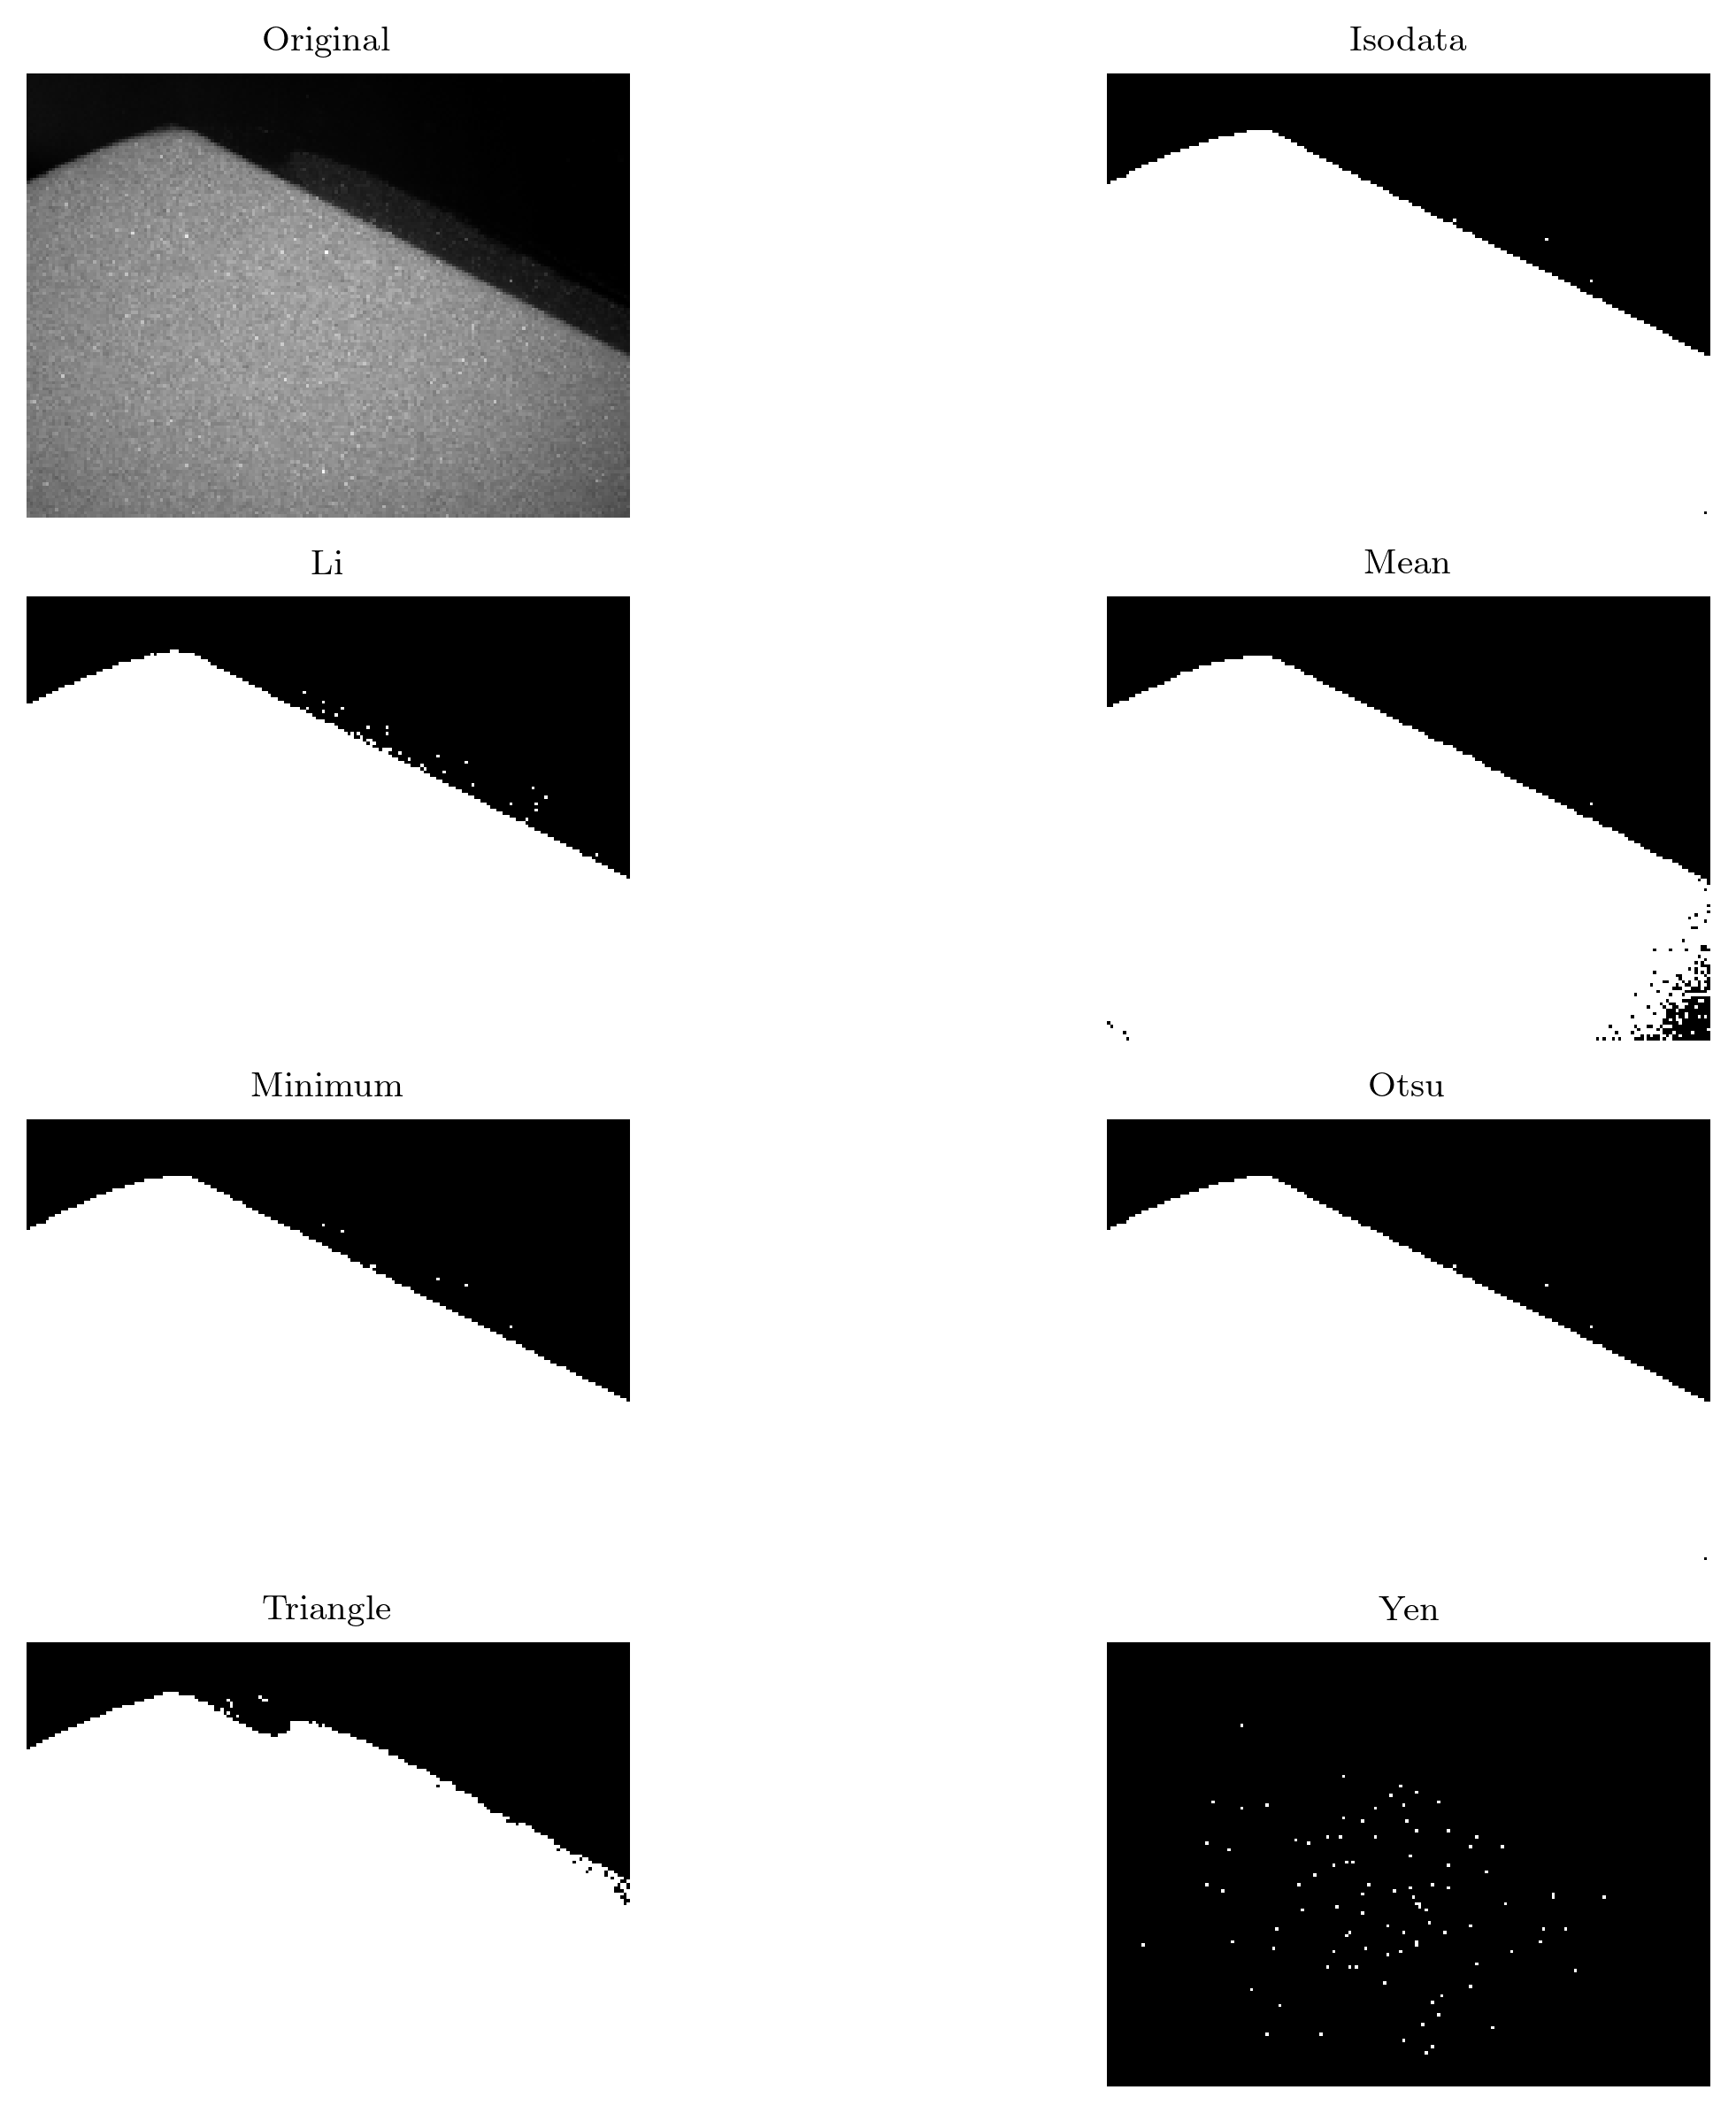

In [6]:
from skimage.filters import try_all_threshold

img = mp_a_mean

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

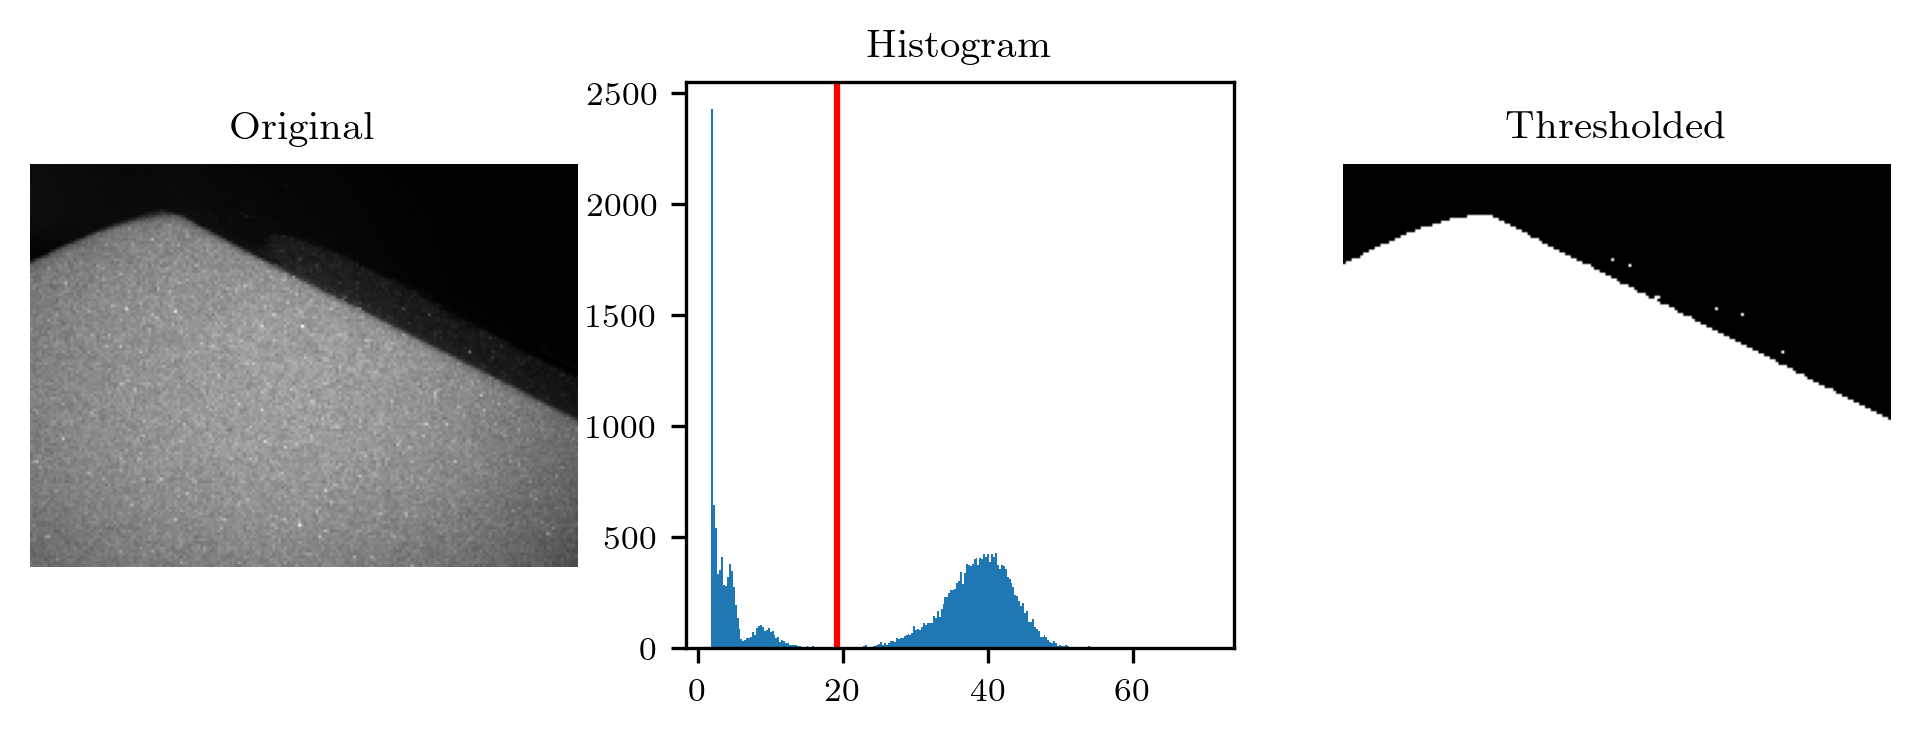

In [7]:
from skimage.filters import threshold_minimum
image = mp_a_mean
thresh = threshold_minimum(image)
binary = image > thresh
mask_heat = ~binary

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

## Calculating G

In [ ]:
# time = np.logspace(1, 13, num=13, base=2)
# time = (0,10,25,50,100,250,500)
time = np.arange (0,250,10)

correlation_heat, means_heat = Calculate_G(image_names,6,time,100)

In [ ]:
#this saves G for 10 cycles of tapping at a single lag
np.savez('/media/nakul/Backup Plus/Data/DWS_Correlation_Outputs/outputs/2020/feb/old_outputs/heat_feb15_0_250_relaxation',data1 = correlation_heat, data2 =  means_heat)

### Loading instantaneous creep rates

In [15]:
heat_dt = np.load('/media/nakul/Backup Plus/Data/DWS_Correlation_Outputs/outputs/2020/feb/old_outputs/heat_feb15_dt.npz')
correlation_heat_dt = heat_dt['data1']
means_heat_dt = heat_dt['data2']

### Loading short-duration correlation functions: post heating (immediately after heating)

The timesteps in the correlation functions are t = 0 - 250 in steps of 10 seconds. each correlation function is composed of 100 lags

In [8]:
heat_short = np.load('/media/nakul/Backup Plus/Data/DWS_Correlation_Outputs/outputs/2020/feb/old_outputs/heat_feb15_0_250_relaxation.npz')
correlation_heat_short = heat_short['data1']
means_heat_short = heat_short['data2']

### Loading long-duration correlation functions: post heating

In [ ]:
heat_long = np.load('/media/nakul/Backup Plus/Data/DWS_Correlation_Outputs/outputs/2020/feb/old_outputs/heat_feb15.npz')
correlation_heat_long = heat_long['data1']
means_heat_long = heat_long['data2']

### Loading preheat/preparation

In [ ]:
heat_prep = np.load('/media/nakul/Backup Plus/Data/DWS_Correlation_Outputs/outputs/2020/feb/old_outputs/undisturbed_feb_13_preheat.npz')
correlation_heat_prep = heat_prep['data1']
means_heat_prep = heat_prep['data2']

## 2d maps

In [12]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

<ipython-input-43-a7e0dbee9dd2>:11: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0] = .00000000000000001


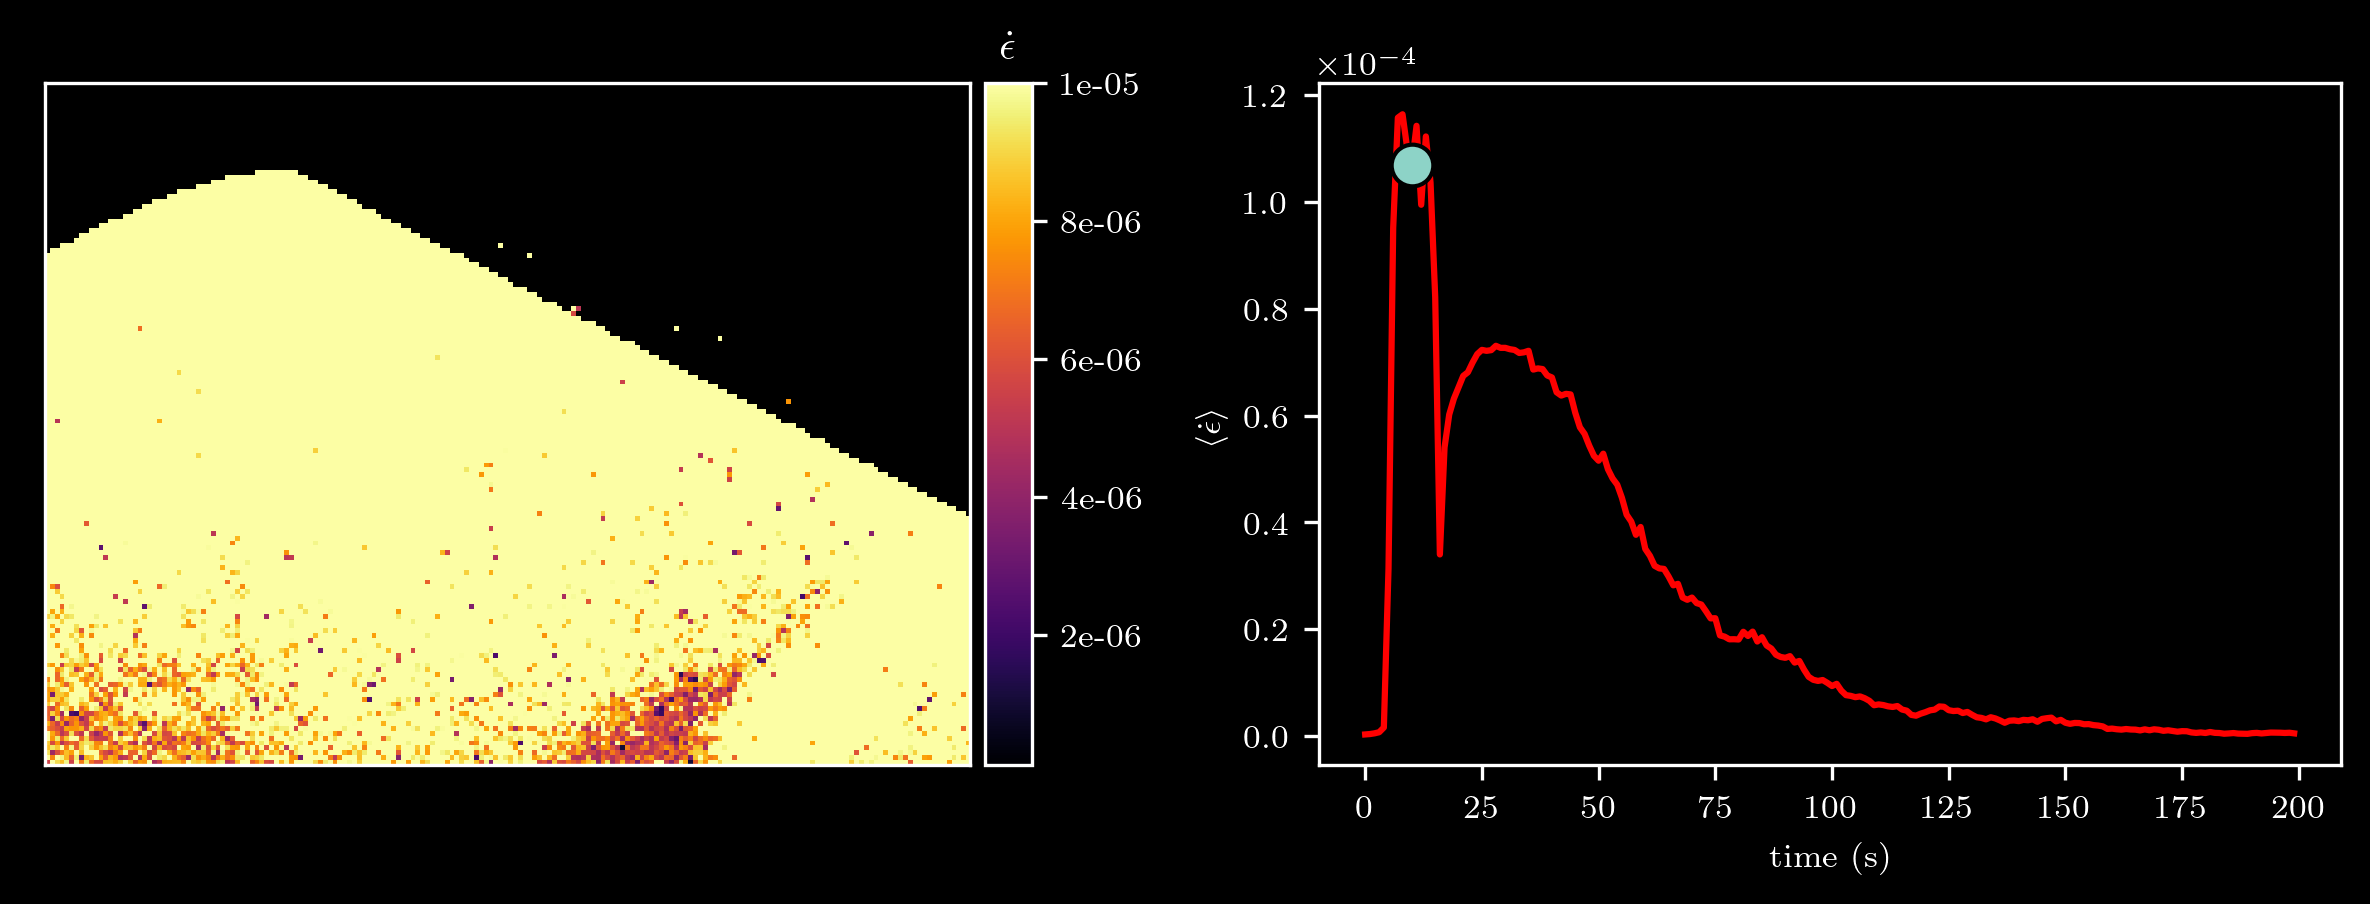

In [43]:
plt.style.use('dark_background')


from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

frame = correlation_heat_short [1][1]
a[a <= 0] = .00000000000000001

masked_map = ma.masked_array(a, mask=mask_heat,fill = 1)

masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno')

cmap = plt.cm.gray_r
cmap.set_bad('white',1.)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax,format='%.0e', orientation='vertical')
# cax.tick_params(labelsize=15) 
cax.set_title('$\dot{\epsilon}$',fontsize = 10)

ax1.set_xticks([]);
ax1.set_yticks([]);




test = []
for i in range(len(means_heat_dt)):
    test.append(means_heat_dt[i][1])
    
i = 10
heat_def = -(np.log(test)/c) 
ax2.plot(heat_def[0:200],'r',alpha =1)
ax2.plot(i,heat_def[i],'o',markersize = 10,markeredgecolor = 'k')


ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.set_ylabel(r'$ \langle \dot{\epsilon} \rangle$',fontsize = 8)
ax2.set_xlabel('time (s)',fontsize = 8)

fig.tight_layout()


# plt.savefig('tapping_t_4000', bbox_inches='tight')

In [47]:
a

25

<ipython-input-52-930766f99828>:21: RuntimeWarning: invalid value encountered in less_equal
  frame[frame <= 0] = .00000000000000001
<ipython-input-52-930766f99828>:21: RuntimeWarning: invalid value encountered in less_equal
  frame[frame <= 0] = .00000000000000001
<ipython-input-52-930766f99828>:21: RuntimeWarning: invalid value encountered in less_equal
  frame[frame <= 0] = .00000000000000001
<ipython-input-52-930766f99828>:21: RuntimeWarning: invalid value encountered in less_equal
  frame[frame <= 0] = .00000000000000001
<ipython-input-52-930766f99828>:21: RuntimeWarning: invalid value encountered in less_equal
  frame[frame <= 0] = .00000000000000001
<ipython-input-52-930766f99828>:21: RuntimeWarning: invalid value encountered in less_equal
  frame[frame <= 0] = .00000000000000001
<ipython-input-52-930766f99828>:21: RuntimeWarning: invalid value encountered in less_equal
  frame[frame <= 0] = .00000000000000001
<ipython-input-52-930766f99828>:21: RuntimeWarning: invalid value enc

IndexError: index 25 is out of bounds for axis 0 with size 25

<Figure size 1800x1800 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

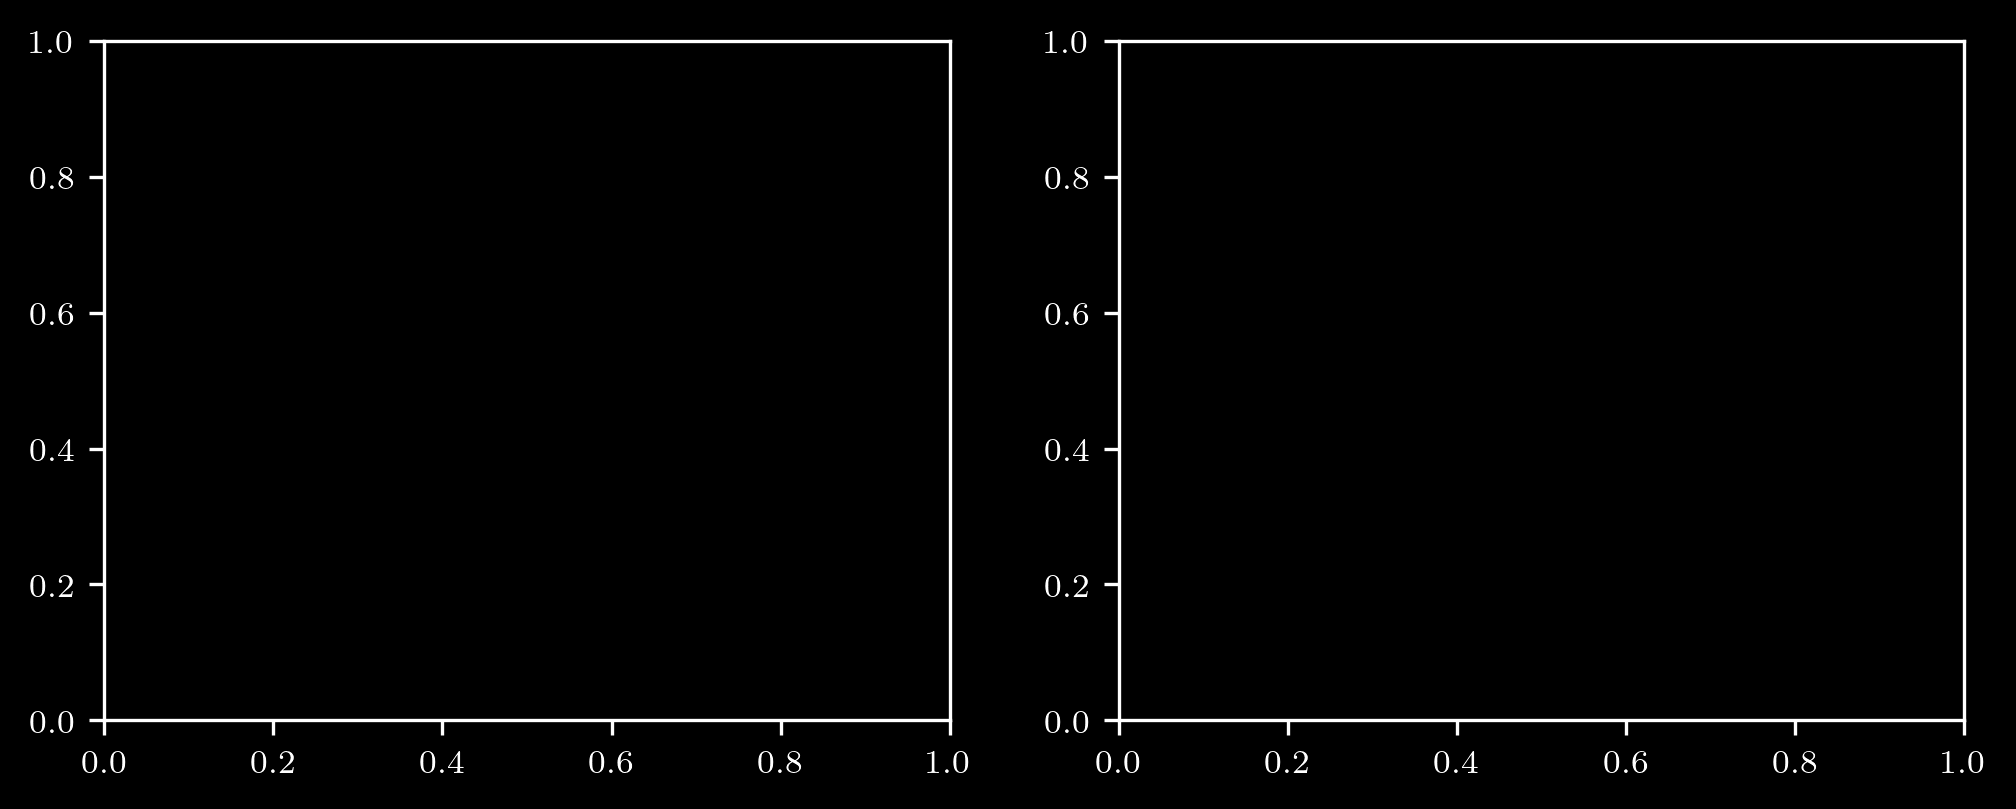

In [52]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(6,6))

a = len(correlation_heat_short)

n = 0

for i in range(200):
    
    plt.style.use('dark_background')


    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig = plt.figure(figsize=(8, 3))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    frame = correlation_heat_short [i][1]
    frame[frame <= 0] = .00000000000000001

    masked_map = ma.masked_array(frame, mask=mask_heat,fill = 1)

    masked_map = -(np.log(masked_map)/c) 

    im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno_r')

    cmap = plt.cm.gray_r
    cmap.set_bad('white',1.)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax,format='%.0e', orientation='vertical')
    # cax.tick_params(labelsize=15) 
    cax.set_title('$\dot{\epsilon}$',fontsize = 10)

    ax1.set_xticks([]);
    ax1.set_yticks([]);


##################################################################################################


    heat_def = -(np.log(test)/c) 
    ax2.plot(heat_def[0:100],'r',alpha =1)
    ax2.plot(i+8,heat_def[i+8],'o',markersize = 10,markeredgecolor = 'k')

    ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax2.set_ylabel(r'$ \langle \dot{\epsilon} \rangle$',fontsize = 8)
    ax2.set_xlabel('time (s)',fontsize = 8)

    fig.tight_layout()


# plt.savefig('tapping_t_4000', bbox_inches='tight')


    plt.savefig("/home/nakul/Documents/Geomorphology/CreepExperiment_videos/heat/heat" + str(n) +".png", format="PNG")
    plt.clf()
    n += 1

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633



fig = plt.figure(figsize=(7, 3))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
#################################################################################################################
frame = correlation_heat_dt[5][1]
frame[frame <= 0] = 0.01
masked_map = ma.masked_array(frame, mask=mask_heat)
masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
# # cax.tick_params(labelsize=15) 
# cax.set_title('$\epsilon$',fontsize = 10)
ax1.annotate('t = 0 s', xy=(5, 5), xytext=(100, 20),fontsize = 12)
# ax1.set_title('t = 4 s')#,fontsize = 20);
# ax1.set_xlim([30,175]);
ax1.set_xticks([]);
ax1.set_yticks([]);
#################################################################################################################
frame = correlation_heat_dt[200][1]
frame[frame <= 0] = 0
masked_map = ma.masked_array(frame, mask=mask_heat)
masked_map = -(np.log(masked_map)/c) 

im2 = ax2.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
# cax.tick_params(labelsize=15) 
cax.set_title(r'$\langle  \dot{\epsilon} \rangle$',fontsize = 10)
ax2.annotate('t = 200 s', xy=(5, 5), xytext=(120, 20),fontsize = 12)

# ax2.set_title('t = 64 s')#,fontsize = 20);
ax2.set_xticks([]);
ax2.set_yticks([]);


plt.subplots_adjust(hspace=.1, wspace=.1, bottom=2, left=.1, top=3)

# # fit subplots and save fig
# fig.set_size_inches(w=7,h=3)
fig.tight_layout()
fig_name = '/home/nakul/Documents/Python Scripts/DWS_Speckle_Analysis/iPython_notebooks/heat_panels.png'
plt.savefig(fig_name, bbox_inches='tight')

## Relaxation curves

In [ ]:
def remove_outliers(x):
    "this function takes a correlation function and filters values."
    "at certain lag times, the mean drops to an anomalous value but is recovered at the subsequent lag time"
    "if the difference between two subsequent timesteps"
    "is greater than the difference between three timesteps, then we set the anomalous value to the previous value"
    for i in range(len(x)-2):
        a = x[i]
        b = x[i+1]
        c = x[i+2]
        d = abs(a-b)
        e = abs(a-c)
        if d > e:
            x[i+1] = x[i]
    return x

### preparation

In [ ]:
from matplotlib.pyplot import cm
a = np.logspace(1, 13, num=13, base=2)
labels = list(a)

color=iter(cm.viridis(np.linspace(0,1,13)))
time = np.arange(1,1001,1)

fig = plt.figure(figsize=(3, 2))
ax1 = plt.subplot(111)

for t in range(13):
    c=next(color)
    corr = remove_outliers(means_heat_prep[t])
    ax1.plot(time,means_heat_prep[t],'o',color = c,markersize = 3,alpha = 1,label = int(labels[t]))

ax1.set_xscale('log')

ax1.set_xlabel(r'$ \tau $ (s)')
ax1.set_ylabel(r'$ \langle G \rangle$')
box = ax1.get_position()
lgd = ax1.legend()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(title = 'time since preparation (s)',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# plt.savefig('correlation_preparation_heat.png', bbox_inches='tight')

### Short - immediately after heat is removed

In [ ]:
a = np.arange(0,250,10)
# a = a*10
labels = list(a)

color=iter(cm.viridis(np.linspace(0,1,25)))
time = np.arange(1,101,1)
y = np.repeat((1/np.exp(1)),100)

fig = plt.figure(figsize=(3, 2))
ax1 = plt.subplot(111)

for t in range(25):
    c=next(color)
    ax1.plot(time,means_heat_short[t],'o',color = c,markersize = 3,alpha = 1,label = int(labels[t]))

ax1.plot(time,y,'k--')
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_xlim([0,1e6])

ax1.set_xlabel(r'$ \tau $ (s)')
ax1.set_ylabel(r'$ \langle G \rangle$')
# box = ax1.get_position()
# lgd = ax1.legend()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(title = 'time since heat removed (s)',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

# plt.tight_layout()

# plt.savefig('correlations_post_heat.png', bbox_inches='tight')

In [ ]:
# ensuring that G goes from 0 to 1
g = means_heat_short
d = np.min(g)
gp_prep = (g-d)/(1-d)

#### efolding time

In [ ]:
t_efold_heat_prep = []
test = []

for i in range(len(means_heat_prep)):
    x = gp_prep[i]
    y = np.where(x < 1/np.exp(1))[0]
    t_efold_heat_prep.append(y[0])

### Short times

In [ ]:
t_efold_short = []
test = []

for i in range(len(means_heat_short)):
    x = means_heat_short[i]
    y = np.where(x < 1/np.exp(1))[0]
    t_efold_short.append(y[0])

In [ ]:
fig = plt.figure(figsize=(2, 2))
t = np.arange(0,130,10)
color=iter(cm.viridis(np.linspace(0,1,13)))

for i in range(len(t_efold_short)):
    plt.plot(t[i],t_efold_short[i],'ro',markeredgecolor = 'k',markersize = 5)

# plt.title('relaxation timescale')
plt.xlabel('t (s)',fontsize = 12)
plt.ylabel(r'$\tau_e$ (s)',fontsize = 12)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([1e-1,1e5])
# plt.ylim([1e1,1e5])

plt.tight_layout()


plt.savefig('e_foldingtime_heat.png', bbox_inches='tight')

## Time Series instantaneous creep

Text(0.5, 0, 'time (s)')

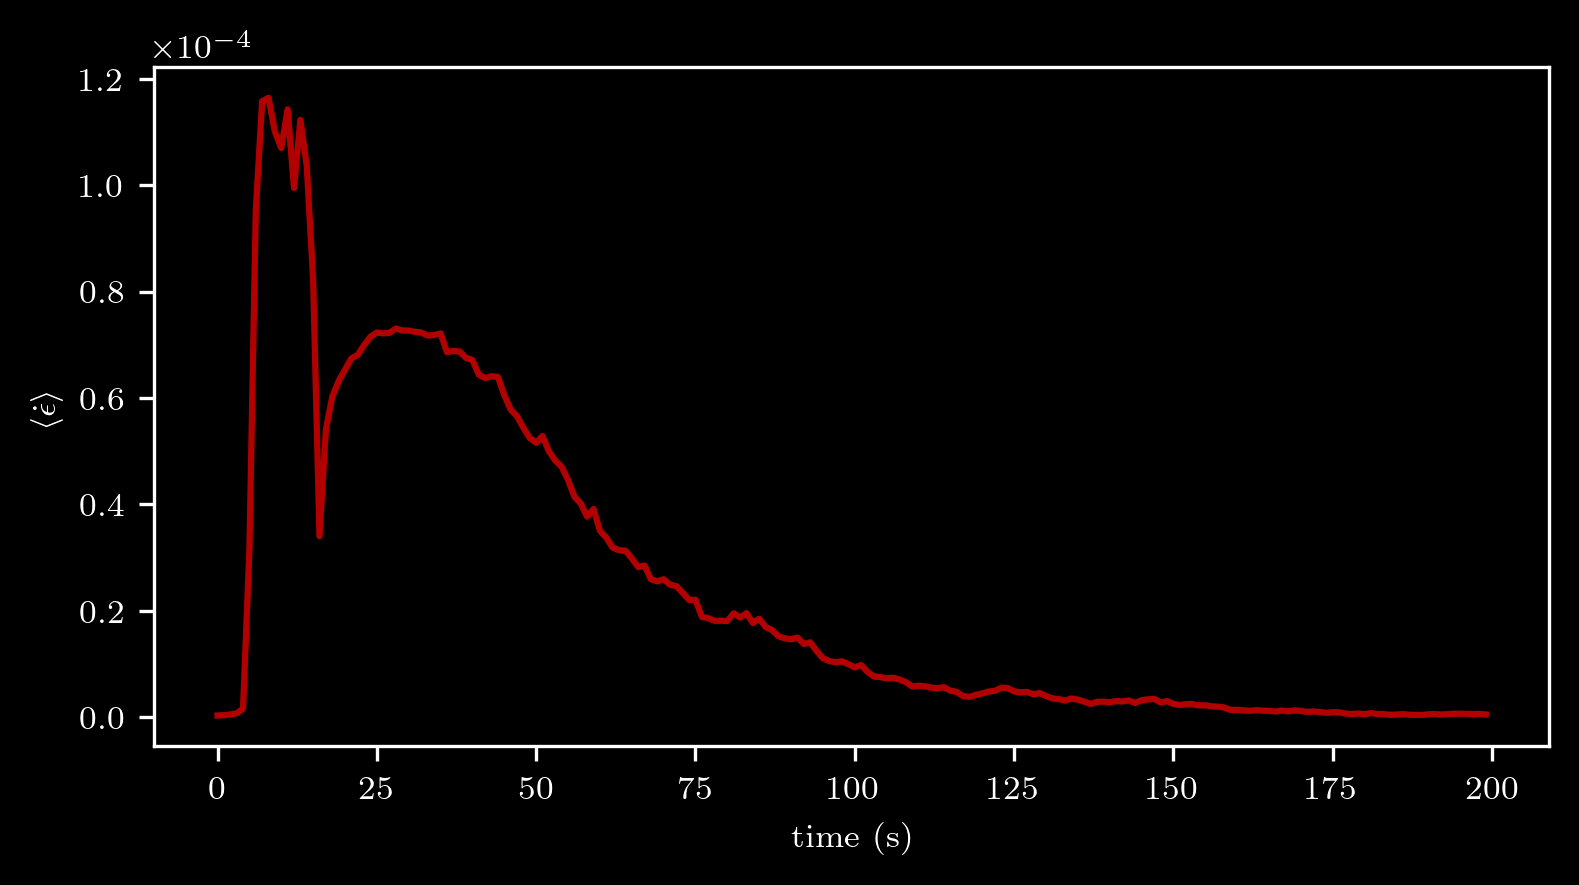

In [33]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633


fig = plt.figure(figsize=(6,3))

test = []
for i in range(len(means_heat_dt)):
    test.append(means_heat_dt[i][1])
    

heat_def = -(np.log(test)/c) 
plt.plot(heat_def[0:200],'r',alpha =0.7)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylabel(r'$ \langle \dot{\epsilon} \rangle$',fontsize = 8)
plt.xlabel('time (s)',fontsize = 8)

# plt.savefig('heat_timeseries.png',bbox_inches='tight')


# Combined map and time series 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

fig = plt.figure(figsize=(3.5,2.5))


#################################################################################################################
ax1 = plt.subplot2grid((2,2), (0, 0), colspan=1,rowspan = 1)


frame = correlation_heat_dt[5][1]
frame[frame <= 0] = 0.01
masked_map = ma.masked_array(frame, mask=mask_heat)
masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('white',1.)


ax1.set_title('t = 0 s')

ax1.set_xticks([]);
ax1.set_yticks([]);
#################################################################################################################
ax2 = plt.subplot2grid((2,2), (0, 1), colspan=1,rowspan = 1)

frame = correlation_heat_dt[200][1]
frame[frame <= 0] = 0
masked_map = ma.masked_array(frame, mask=mask_heat)
masked_map = -(np.log(masked_map)/c) 

im2 = ax2.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

cmap = plt.cm.gray
cmap.set_bad('white',1.)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical',format=ticker.FuncFormatter(fmt))
# cax.set_title(r'$\langle  \dot{\epsilon} \rangle$',fontsize = 10)
ax2.set_title('t = 200 s')

ax2.set_xticks([]);
ax2.set_yticks([]);

################################################################################################################
ax3 = plt.subplot2grid((2,2), (1, 0), colspan=2,rowspan = 2)


ax3.plot(heat_def[3:203],'r',alpha = 0.7)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax3.set_ylabel(r'$ \langle \dot{\epsilon} \rangle$ [$s^{-1}$]')#,rotation = 'horizontal')
ax3.set_xlabel('time (s)')
################################################################################################################
left, bottom, width, height = [0.6, 0.25, 0.20, 0.2]

ax4 = fig.add_axes([left, bottom, width, height])

time_short = np.arange (0,250,10)

for i in range(len(t_efold_short)):
    ax4.plot(time_short[i],t_efold_short[i],'ro',markeredgecolor = 'k',markersize = 5)
    
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.tick_params(axis='both', which='major', labelsize=7)
ax4.xaxis.set_ticks([1,10,100,1000])
ax4.yaxis.set_ticks([1,10,100])
ax4.set_ylim([1,200])
ax4.set_xlabel('t (s)')
ax4.set_ylabel(r'$\tau_e$ (s)',rotation = 'horizontal')
ax4.yaxis.set_label_coords(-0.6, .5)
ax4.xaxis.set_label_coords(1.3, 0)
################################################################################################################



# plt.subplots_adjust(hspace=.1, wspace=.1, bottom=2, left=.1, top=3)

# # # fit subplots and save fig
# # fig.set_size_inches(w=7,h=3)
# fig.tight_layout()
fig_name = '/home/nakul/Documents/Python Scripts/DWS_Speckle_Analysis/iPython_notebooks/heat_panels.pdf'
plt.savefig(fig_name, bbox_inches='tight')

In [ ]:
import matplotlib.patheffects as pe
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(7,2))
ax1 = plt.subplot(111)
################################################################################################################
ax1.plot(heat_def[3:203],'r',alpha = 0.7)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax1.set_ylabel(r'$ \langle \dot{\epsilon} \rangle$')
ax1.set_xlabel('time (s)')
################################################################################################################
left, bottom, width, height = [0.65, 0.3, 0.20, 0.5]

ax2 = fig.add_axes([left, bottom, width, height])

time_short = np.arange (0,250,10)

for i in range(len(t_efold_short)):
    ax2.plot(time_short[i],t_efold_short[i],'ro',markeredgecolor = 'k',markersize = 5)
    
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.xaxis.set_ticks([1,10,100,1000])
ax2.yaxis.set_ticks([1,10,100])
ax2.set_ylim([1,200])
ax2.set_xlabel('t (s)')
ax2.set_ylabel(r'$\tau_e$ (s)')
################################################################################################################

# plt.tight_layout()
# plt.savefig('heat.png', bbox_inches='tight')

In [ ]:
import matplotlib.patheffects as pe
from matplotlib.pyplot import cm

#(figsize=(3.5,6))
fig = plt.figure(figsize=(6,4.5))
ax1 = plt.subplot(211)

ax1.plot(heat_def,'r',alpha = 0.7)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax1.set_ylabel(r'$\dot{\epsilon }$',fontsize = 7)
ax1.set_xlabel('time (s)',fontsize = 7)

################################################################################################################
left, bottom, width, height = [0.65, 0.65, 0.20, 0.20]
ax2 = fig.add_axes([left, bottom, width, height])

time_short = np.arange (0,250,10)

# t = (np.logspace(1, 13, num=13, base=2))
color=iter(cm.inferno(np.linspace(0,1,13)))

for i in range(len(t_efold_short)):
    c=next(color)
    ax2.plot(time_short[i],t_efold_short[i],'ro',markeredgecolor = 'k',color = c,markersize = 5)
    
ax2.yaxis.set_ticks([0,25,50])
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.yaxis.set_label_coords(-0.025,1.05)

ax2.set_xlabel('time since heating (s)')
ax2.set_ylabel('decay time (s)',rotation = 'horizontal')
################################################################################################################
left, bottom, width, height = [0.35, 0.65, 0.20, 0.20]
ax3 = fig.add_axes([left, bottom, width, height])

color=iter(cm.inferno(np.linspace(0,1,12)))
time = np.arange(1,101,1)

for t in range(len(t_efold_short)):
    c=next(color)
    ax3.plot(time,means_heat_short[t],'o',color = c,markersize = 3.5,alpha = 1)#,label = int(labels[t]))

ax3.set_xscale('log')
# ax3.set_yscale('log')
# ax1.set_xlim([0,1e6])

ax3.set_xlabel('lag (s)')
ax3.set_ylabel('G',rotation = 'horizontal')
ax3.yaxis.set_label_coords(-0.025,1.05)

plt.tight_layout()


# plt.savefig('/home/nakul/Documents/Python Scripts/DWS_Speckle_Analysis/iPython_notebooks/heat_timeseries.png', bbox_inches='tight')

In [ ]:
color=iter(cm.viridis(np.linspace(0,1,12)))
time = np.arange(1,101,1)

for t in range(len(t_efold_short)):
    c=next(color)
    plt.plot(time,means_heat_short[t],'o',color = c,markersize = 3.5,alpha = 0.7)#,label = int(labels[t]))

ax3.set_xscale('log')
# ax3.set_yscale('log')
# ax1.set_xlim([0,1e6])

ax3.set_xlabel('lag (s)')
ax3.set_ylabel('G',rotation = 'horizontal')
ax3.yaxis.set_label_coords(-0.025,1.05)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 3))

# fig.suptitle('t 9000 -> 9100')


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1,rowspan = 2)

ax1.plot(heat_def,'r')

ax1.set_xlabel('$\epsilon$')
ax1.set_ylabel('z (m)')
# ax1.set_xlim([-1e-4,1e-5])
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))


# plt.xscale('log')
# plt.yscale('log')


####################################################################################################################
ax2 = plt.subplot2grid((3, 3), (0, 1), rowspan=1,colspan = 1)

frame = correlation_heat_dt[5][1]
frame[frame <= 0] = 1e-32
masked_map = ma.masked_array(frame, mask=mask_heat)
masked_map = -(np.log(masked_map)/c) 

im2 = ax2.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')


divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')

ax2.set_title('t = 1')
ax2.set_xticks([])
ax2.set_yticks([])
####################################################################################################################
ax3 = plt.subplot2grid((3, 3), (0, 2), rowspan=1,colspan = 1)

frame = correlation_heat_dt[100][1]
frame[frame <= 0] = 1e-32
masked_map = ma.masked_array(frame, mask=mask_heat)
masked_map = -(np.log(masked_map)/c) 

im3 = ax3.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')

ax3.set_title('t = 3')
ax3.set_xticks([])
ax3.set_yticks([])
####################################################################################################################
ax4 = plt.subplot2grid((3, 3), (1, 1), rowspan=1,colspan = 1)

frame = correlation_heat_dt[200][1]
frame[frame <= 0] = 1e-32
masked_map = ma.masked_array(frame, mask=mask_heat)
masked_map = -(np.log(masked_map)/c) 

im4 = ax4.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')


divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')

ax4.set_title('t = 20')
ax4.set_xticks([])
ax4.set_yticks([])
####################################################################################################################

ax5 = plt.subplot2grid((3, 3), (1, 2), rowspan=1,colspan = 1)
frame = correlation_heat_dt[300][1]
frame[frame <= 0] = 1e-32
masked_map = ma.masked_array(frame, mask=mask_heat)
masked_map = -(np.log(masked_map)/c) 

im5 = ax5.imshow(masked_map,vmin = 1e-7,vmax = 1e-5,cmap = 'gray_r')

divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im5, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')

ax5.set_title('t = 90')
ax5.set_xticks([])
ax5.set_yticks([])

plt.subplots_adjust(hspace=.1, wspace=.1, bottom=2, left=.1, top=3)

# plt.tight_layout()

# plt.savefig('ensemble_test.png', bbox_inches='tight')

In [ ]:
import matplotlib.patheffects as pe
from matplotlib.pyplot import cm

#(figsize=(3.5,6))
fig = plt.figure(figsize=(6,3))
ax1 = plt.subplot(211)

ax1.plot(heat_def,'r',alpha = 0.7)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax1.set_ylabel(r'$\dot{\epsilon }$',fontsize = 7)
################################################################################################################
left, bottom, width, height = [0.5, 0.7, 0.30, 0.20]
ax2 = fig.add_axes([left, bottom, width, height])

time_short = np.arange (0,250,10)

# t = (np.logspace(1, 13, num=13, base=2))
color=iter(cm.viridis(np.linspace(0,1,13)))

for i in range(len(t_efold_short)):
    c=next(color)
    ax2.plot(time_short[i],t_efold_short[i],'o',markeredgecolor = 'k',color = c,markersize = 5)
    
ax2.yaxis.set_ticks([0,25,50])
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.yaxis.set_label_coords(-0.025,1.05)

ax2.set_xlabel('start time (s)')
ax2.set_ylabel('decay time (s)',rotation = 'horizontal')
##############################################################################################################
ax3 = plt.subplot(212)
ax3.plot(tap_def[10:5010],color='b',alpha = 0.5)
ax3.plot(smoothed_taps[10:5010],color='k')

# ax3.plot(a[10:510],'k')
ax3.set_xlabel('time (s)')
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax3.set_ylabel(r'$\dot{\epsilon }$',fontsize = 7)

plt.tight_layout()
# plt.savefig('disturbance_timeseries.png')

## Multicycle Heating

In [ ]:
heat_multicycle = np.load('/home/ndeshpande/Documents/Python Scripts/DWS_Speckle_Analysis/outputs/2019/heat_multicycle.npz')
# correlation_heat_multicycle = heat_multicycle ['data1']
means_heat_multicycle = heat_multicycle ['data2']

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

heat_multicycle = []

for i in range(len(means_heat_multicycle)):
    heat_multicycle.append(-(np.log(means_heat_multicycle[i][1])/c) )

# Multicycle comparison

In [ ]:
undisturbed_multicycle = np.load('/home/ndeshpande/Documents/Python Scripts/DWS_Speckle_Analysis/outputs/2019/purecreep_C.npz')
# correlation_undisturbed_multicycle = undisturbed_multicycle ['data1']
means_undisturbed_multicycle = undisturbed_multicycle ['data2']

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633

undisturbed_multicycle = []

for i in range(len(means_undisturbed_multicycle)):
    undisturbed_multicycle.append(-(np.log(means_undisturbed_multicycle[i][1])/c) )

In [ ]:
fig = plt.figure(figsize=(8, 2))

mean_heat = np.mean(heat_multicycle[261:1600])
mean_heat = np.repeat(mean_heat,1600-261)

time = np.arange(0,1600-261,1)

# plt.plot(undisturbed_multicycle[0:1500])
# plt.plot(tapping_multicycle[0:1700],'k',alpha = 0.5,label = 'tapping')
plt.plot(heat_multicycle[261:1600],'r',alpha = 0.5,label = 'heating')
plt.plot(time,mean_heat,'k--',alpha = 0.7)


# plt.yscale('log')
# plt.ylim([1e-7,1e-2])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylabel(r'$ \langle \dot{\epsilon} \rangle$',fontsize = 12)
plt.xlabel('time (s)')

# plt.tight_layout()
plt.savefig('heat_cycles.png', bbox_inches='tight')

# Ensemble timeseries

In [ ]:
import matplotlib.patheffects as pe
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(7,2))
ax1 = plt.subplot(121)
################################################################################################################
ax1.plot(heat_def[3:203],'r',alpha = 0.7)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax1.set_ylabel(r'$ \langle \dot{\epsilon} \rangle$')
ax1.set_xlabel('time (s)')
################################################################################################################
left, bottom, width, height = [0.6, 0.65, 0.20, 0.20]
ax2 = fig.add_axes([left, bottom, width, height])

time_short = np.arange (0,250,10)

for i in range(len(t_efold_short)):
    ax2.plot(time_short[i],t_efold_short[i],'ro',markeredgecolor = 'k',markersize = 5)
    
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.xaxis.set_ticks([1,10,100,1000])
ax2.yaxis.set_ticks([1,10,100])
ax2.set_ylim([1,200])
ax2.set_xlabel('t (s)')
ax2.set_ylabel(r'$\tau_e$ (s)')
################################################################################################################
ax3 = plt.subplot(122)

tap_def = -(np.log(test)/c) 
ax3.plot(tap_def[10:5010],'b',alpha =0.3)
ax3.plot(smoothed_taps[10:5010],'-k')
ax3.set_xlabel('tap number')
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax3.set_ylabel(r'$ \langle \dot{\epsilon} \rangle$')

plt.tight_layout()
# plt.savefig('ensemble_disturbance_timeseries.png', bbox_inches='tight')

# Ensemble Disturbance maps

In [ ]:
fig = plt.figure(figsize=(4, 4))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# fig.suptitle('heating test - 10 cycles')
#################################################################################################################
heat = correlation_heat_cycles[t][1]
heat[heat <= 0] = 1e-32
heat_mask = ma.masked_array(heat, mask=mask_heating_cycles)
heat_mask = -(np.log(heat_mask)/c) 

im1 = ax1.imshow(heat_mask,cmap = 'gray_r',vmin = 1e-7, vmax = 1e-4)
ax1.set_title('heating',fontsize = 4)
ax1.set_xticks([])
ax1.set_yticks([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')

#################################################################################################################
tap = correlation_tapping_cycles[t][1]
tap[tap <= 0] = 1e-32
tap_mask = ma.masked_array(tap, mask=mask_tapping_cycles)
tap_mask = -(np.log(tap_mask)/c) 

im2 = ax2.imshow(tap_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
ax2.set_title('tapping',fontsize = 4)
ax2.set_xticks([])
ax2.set_yticks([])

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')


plt.tight_layout()

# plt.savefig('heating_tapping.png')

## Disturbance Time Series

In [ ]:
fig = plt.figure(figsize=(5, 3))
time = np.arange(0,3000,.5)

# ax1 = plt.subplot(3, 1, 1)
# ax1.plot(time,undisturbed_def[:6000],'k',linewidth = 1,alpha = 0.5, label = 'undisturbed')
# ax1.set_yscale('log')
# ax1.set_xlim([0,1000])

ax2 = plt.subplot(3, 1, 2)
ax2.plot(heat_def[0:500],'r',linewidth = 1,alpha = 1,label = 'heating')
ax2.set_yscale('log')
ax2.set_xlim([0,1000])


ax3 = plt.subplot(3, 1, 3)
ax3.plot(tap_def[30:6030],'b',linewidth = 1,alpha = 1,label = 'tapping')
ax3.set_yscale('log')
ax3.set_xlim([0,1000])

plt.tight_layout()

# plt.savefig('disturbances_test.png')

## Ensemble multicycle disturbance movies

In [ ]:
n = 0
fig = plt.figure(figsize=(4, 4))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)


for t in range(160):
    ax1 = plt.subplot(2, 1, 1)
    ax2 = plt.subplot(2, 1, 2)

    #################################################################################################################
    heat = correlation_heat_cycles[t][1]
    heat[heat <= 0] = 1e-32
    heat_mask = ma.masked_array(heat, mask=mask_heating_cycles)
    heat_mask = -(np.log(heat_mask)/c) 

    im1 = ax1.imshow(heat_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
    ax1.set_title('heating',fontsize = 4)
    ax1.set_xticks([])
    ax1.set_yticks([])

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
    cax.set_title('$\epsilon$')

    #################################################################################################################
    tap = correlation_tapping_cycles[t][1]
    tap[tap <= 0] = 1e-32
    tap_mask = ma.masked_array(tap, mask=mask_tapping_cycles)
    tap_mask = -(np.log(tap_mask)/c) 

    im2 = ax2.imshow(tap_mask,vmin = 1e-7, vmax = 1e-5, cmap = 'gray_r')
    ax2.set_title('tapping',fontsize = 4)
    ax2.set_xticks([])
    ax2.set_yticks([])

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
    cax.set_title('$\epsilon$')


    plt.tight_layout()
    
    plt.savefig("ensmble_test" + str(n) +".png", format="PNG")
    plt.clf()
    n += 1

In [ ]:
# mpl.rc('text', usetex = True)
# mpl.rc('font', family = 'serif')
fig = plt.figure(figsize=(6, 4))

#############################################################################################################
ax1 = plt.subplot2grid((2, 3), (1, 0), rowspan=1,colspan = 3)


ax1.plot(heat_def[10:3500],'r',linewidth = 1)
ax1.plot(tap_def[10:3500],'b',linewidth = 1)
ax1.set_xlabel('time (seconds)')
ax1.set_ylabel(r'$\dot{\epsilon }$',fontsize = 12)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax1.set_ylim(0,0.0004)
ax1.set_xlim(-10,3500)


# ax1.set_yscale('log')
# ax1.set_ylim([1e-7,1e-3])
#############################################################################################################
ax2 = plt.subplot2grid((2, 3), (0, 2), rowspan=1,colspan = 1)

# labels = list(time)
# labels = list(np.logspace(1, 13, num=13, base=2))
labels = np.arange (0,300,5)

# t = np.arange(0,10,.1)

color=iter(cm.viridis(np.linspace(0,1,60)))

for t in range(60):
    c=next(color)
    ax2.plot(means_heat_single_cycle_response[t],'-',color = c,linewidth = 1)#,label = int(labels[t]))

ax2.set_title('heating')
ax2.set_xscale('log')
ax2.set_xlabel(r'$\tau$')
ax2.set_yticks([]);


# box = ax2.get_position()
# lgd = ax2.legend()
# ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax2.legend(title = 'start time',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))
#############################################################################################################
ax3 = plt.subplot2grid((2,3), (0,1), colspan=1,rowspan = 1)

# labels = list(time)
labels = list(np.logspace(1, 13, num=13, base=2))
color=iter(cm.viridis(np.linspace(0,1,13)))

for t in range(13):
    c=next(color)
    ax3.plot(means_tap_single_cycle_response[t],'-',color = c,linewidth = 1)

ax3.set_title('tapping')
ax3.set_yticks([]);
ax3.set_xscale('log')
# ax3.set_yscale('log')
ax3.set_xlabel(r'$\tau$')

# ax3.set_ylim([0,1.1])


# box = ax1.get_position()
# lgd = ax1.legend()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(title = 'start time',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))
#############################################################################################################
ax4 = plt.subplot2grid((2,3), (0,0), colspan=1,rowspan = 1)

# labels = list(time)
# labels = list(np.logspace(1, 13, num=13, base=2))

# t = np.arange(0,10,.1)

color=iter(cm.viridis(np.linspace(0,1,13)))

for t in range(13):
    c=next(color)
    ax4.plot(means_undisturbed[t],color = c,linewidth = 1)#,label = int(labels[t]))

ax4.set_title('undisturbed')
ax4.set_xscale('log')
ax4.set_xlabel(r'$\tau$')
# ax4.set_yticks([]);
ax4.set_ylabel('G')


fig.tight_layout()

# # fit subplots and save fig
fig.tight_layout()
# fig.set_size_inches(w=7,h=4)
# fig_name = 'fig2_glassytime.pdf'
plt.savefig(fig_name)

## Movie/Animation frames

In [ ]:
# fig = plt.figure(figsize=(2, 2))

# ax1 = plt.subplot(1, 1, 1)

n = 0

for i in range(len(correlation_tapping)):
    
    ax1 = plt.subplot(1, 1, 1)

    frame = correlation_tapping[i+100][1]
    masked_map = ma.masked_array(frame, mask=mask_tapping)
    # masked_map = -(np.log(masked_map)/c) 

    im1 = ax1.imshow(masked_map,vmin = .9,vmax = 1,cmap = 'gray')

    cmap = plt.cm.gray
    cmap.set_bad('white',1.)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    cax.set_title('Correlation (G)',fontsize = 8)
    ax1.annotate("# of taps " + str(n), xy=(5, 5), xytext=(120, 20),fontsize = 8)
    ax1.set_xticks([]);
    ax1.set_yticks([]);

    plt.savefig("test" + str(n+100) +".png", format="PNG")
    plt.clf()
    n += 1

# Loading Temperature/Humidity sensor readout

In [ ]:
import pandas as pd


environment = pd.read_csv('/home/ndeshpande/Desktop/Hayden_Feb_01_05_2020.txt',skiprows=1, sep=',', usecols = range(0,5), names = ['id', 'time','celsius','humidity','dew point'])
environment = environment.values.tolist()

a = len(environment)

time = []
humidity = []
temperature = []
dew_point = []

for i in range(a):
    time.append(environment[i][1])
    temperature.append(environment[i][2])
    humidity.append(environment[i][3])
    dew_point.append(environment[i][4])

In [ ]:
# Create some mock data

time_sensor = np.arange(1,5820,5)
time_sensor = time_sensor/60/24

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (days)')
ax1.set_ylabel('temperature(C)', color='r')
ax1.plot(time_sensor,temperature, color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('% relative humidity', color='b')  # we already handled the x-label with ax1
ax2.plot(time_sensor,humidity, color='b')
ax2.tick_params(axis='y', labelcolor='b')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig('temp_humidty.png')

In [ ]:
fig = plt.figure(figsize=(4, 4))

start_times = (81,81,81,81,82,83,85,89,98,115,149,217,354)

time_sensor = np.arange(1,1670,5)
time_sensor = time_sensor/60

plt.plot(time_sensor,humidity[81:415],linewidth = 2)
plt.xlabel('time')
plt.ylabel('% relative humidity')
plt.xlabel('time (hours)')

plt.savefig('temp_humidty_day1.png')